# DFINE Tutorial
## Overview

DFINE, which stands for **Dynamical Flexible Inference for Nonlinear Embeddings**, is a neural network model that is developed to enable flexible inference, whether causally, non-causally, or even in the presence of missing neural observations. To enable flexible inference, a model must achieve all the following operations simultaneously, without the need to retrain a new model or change the inference structure:

1\) Causal inference (filtering) <br>
2\) Non-causal inference (smoothing) <br>
3\) Account for missing observations, which can occur in wireless neural interfaces

DFINE achieves flexible inference. Also, DFINE’s inference is recursive and thus computationally efficient. Flexible inference is essential for developing neurotechnology, such as brain-machine interfaces (BMIs).

### Model Architecture
To achieve flexible inference, DFINE separates the model into jointly trained manifold and dynamic latent factors such that nonlinearity is captured through the manifold factors and the dynamics can be modeled in tractable linear form on this nonlinear manifold. Also, as its training loss, DFINE can use the future-step-ahead neural prediction error because of its flexible inference capability that allows it to efficiently and recursively compute this loss during training.

Specifically, we define the two sets of latent factors as follows: 1) Manifold latent factors ${a}_t \in \mathbb{R}^{n_a \times 1}$ and 2) Dynamic latent factors ${x}_t \in \mathbb{R}^{n_x \times 1}$.

First, the dynamic latent factors evolve in time with a linear Gaussian model: $\begin{equation}{x}_{t+1} = A{x}_t + {w}_t\tag{1}\end{equation}$ where $A \in \mathbb{R}^{n_x \times n_x}$ is the state transition matrix and ${w}_t \in \mathbb{R}^{n_x \times 1}$ is zero-mean Gaussian noise with covariance matrix $W \in \mathbb{R}^{n_x \times n_x}$. The manifold latent factors ${a}_t$ are related to the dynamic latent factors ${x}_t$ as: $\begin{equation}{a}_t = C{x}_t + {r}_t\tag{2}\end{equation}$ where $C \in \mathbb{R}^{n_a \times n_x}$ is the emission matrix and ${r}_t \times \mathbb{R}^{n_a \times 1}$ is white Gaussian noise with covariance matrix $R \in \mathbb{R}^{n_a \times n_a}$. Equations (1) and (2) form an LDM with learnable parameters $\psi = \{ A, C, W, R, {\mu}_0, \Lambda_0 \}$ where ${\mu}_0$ and $\Lambda_0$ are the initial estimate and covariance of dynamic latent factors, respectively.

Second, to model nonlinear mappings, we used MLP autoencoders to learn the mapping between neural observations ${y}_t$ and manifold latent factors ${a}_t$. We model the decoder part as a nonlinear mapping $f_\theta(\cdot)$ from manifold latent factors to neural observations: $\begin{equation}{y}_t = f_\theta({a}_t) + {v}_t\tag{3}\end{equation}$ where $\theta$ are parameters and ${v}_t \in \mathbb{R}^{n_y \times 1}$ is a white Gaussian noise with covariance $V \in \mathbb{R}^{n_y \times n_y}$. Equations (1)-(3) together form the generative model.

For inference, we also need the mapping from ${y}_t$ to ${a}_t$, which we characterize as: $\begin{equation}{a}_t = f_\phi ({y}_t)\tag{4}\end{equation}$ where $f_\phi(\cdot)$ represents the encoder in the autoencoder structure and is parameterized by another MLP. All equations above are trained together end-to-end, rather than separately. Further, the middle manifold layer in equation (2) explicitly incorporates a
stochastic noise variable $r_t$, whose covariance is learned during training, allowing the nonlinearity with respect to the dynamic latent factors to be stochastic in DFINE. To help with robustness to noise and stochasticity during inference, DFINE learns all the stochastic noise distribution parameters during training, which are then explicitly accounted for at inference.


### The Inference Problem
Using the equations above, we can infer both the manifold and dynamic latent factors from neural observations ${y}_{1:T}$, where $T$ is the total number of time steps for the observations. We use subscript $t|k$ to denote the inferred latent factors at time $t$ given observations up to time $k$, ${y}_{1:k}$. Thus, $t|t$ denotes filtering (causal) inference given ${y}_{1:t}$, $t+k|t$ denotes the $k$-step-ahead prediction given $y_{1:t}$, and $t|T$ denotes smoothing (non-causal) inference given ${y}_{1:T}$.

The inference method is shown in Figure 1b in the paper and is as follows. We first directly but statically obtain an initial estimate of ${a}_t$ based on ${y}_t$ with ${\hat{a}}_t = f_\phi({y}_t)$ in equation (4), to provide the noisy observations of the dynamical model, that is, ${\hat{a}}_t$. Having obtained ${\hat{a}}_t$, we can now use the dynamical part of the model in equations (1) and (2) to infer ${x}_{t|t}$ with Kalman filtering from ${\hat{a}}_{1:t}$, and infer ${x}_{t|T}$ with Kalman smoothing from ${\hat{a}}_{1∶T}$. We can then infer the manifold latent factor as ${a}_{t|t} = C{x}_{t|t}$ and ${a}_{t|T} = C{x}_{t|T}$ on the basis of equation (2). Similarly, we can obtain the filtered neural activity ${y}_{t|t}$ and smoothed neural activity ${y}_{t|T}$ using equation (3) as ${y}_{t|t} = f_{\theta}({a}_{t|t})$ and ${y}_{t|T} = f_{\theta}({a}_{t|T})$, respectively.

To obtain the $k$-step-ahead predicted neural activity ${y}_{t+k|t}$, we first recursively forward predict the dynamic latent factors $k$ time-steps with the Kalman predictor, and obtain ${x}_{t+k|t}$. Then, we can compute the $k$-step-ahead predictions of manifold latent factors and neural observations with ${a}_{t+k|t} = C{x}_{t+k|t}$ and ${y}_{t+k|t} = f_{\theta}({a}_{t+k|t})$, respectively.

### Training Loss Function
Having established the DFINE model and its inference, we can learn the model parameters $\psi, \theta, \phi$ by minimizing:  $\begin{equation}L(\psi, \theta, \phi) = \sum_{k=1}^K \sum_{t=1}^{T-k} e({y}_{t+k|t}, {y}_{t+k}) + \lambda_{reg} L_2 (\theta, \phi)\tag{5}\end{equation}$ where $K$ denotes the maximum horizon for future-step-ahead prediction, $e(\cdot, \cdot)$ denotes the error measure which is taken as mean-squared error (MSE) loss, $L_2(\cdot)$ is L2 regularization for the autoencoder parameters $\{\theta, \phi\}$ to prevent overfitting, and $\lambda_{reg}$ is the L2 regularization loss scale (see config_dfine.py).

### Training tips and hyperparameters
DFINE does not have many hyperparameters to tune. Yet **it may be necessary to search over a grid of the following hyperparameters to find the best performing ones for a given dataset (especially for L2 regularization loss scale)**:
- L2 regularization loss scale, config.loss.scale_l2. For hyperparameter search, you can use a small grid such as [1e-4, 5e-4, 1e-3, 2e-3] after z-scoring the signals (see below).
- $K$, future-step-ahead prediction horizon provided as a list, config.loss.steps_ahead
- Encoder/decoder architecture, i.e., number of hidden layers and units in each layer, config.model.hidden_layer_list
- Setting $n_a$ higher than $n_y$ may lead to overfitting, it's recommended that $n_a \leq n_y$
- As we show in Extended Data Fig. 8, it's recommended to set $n_a = n_x$ to reduce the hyperparameter search complexity

For default values of all hyperparameters, please see config_dfine.py. For the future-step-ahead prediction horizon, we used $K=4$, or config.loss.steps_ahead = [1,2,3,4] for DFINE.

It is important to note that for neural signals, we performed **z-scoring** which is highly recommended, please see below and time_series_utils.z_score_tensor. Recommendations above for L2 regularization scale are with z-scoring, which can affect the choice of L2 regularization scale.


**DFINE is currently implemented for continuous-valued signals**.

In [1]:
%matplotlib inline

import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from config_dfine import get_default_config
from trainers.TrainerDFINE import TrainerDFINE
from datasets import DFINEDataset
from time_series_utils import z_score_tensor, get_nrmse_error

import h5py
import numpy as np
import os

def set_seed(seed=0):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
def train_test_split(y, train_ratio, batch_size = 32):
# Split data into training and test datasets
    num_trials = y.shape[0]
    num_train_trials = int(train_ratio * num_trials)
    num_test_trials = num_trials - num_train_trials
    train_y = y[:num_train_trials, ...]
    test_y = y[num_train_trials:, ...]

    # Z-score the observation tensors
    train_y_zsc, mean_y, std_y = z_score_tensor(train_y, fit=True)
    test_y_zsc, _, _ = z_score_tensor(test_y, mean=mean_y, std=std_y, fit=False)

    # Create DFINE dataset objects and torch dataloaders
    train_dataset = DFINEDataset(y=train_y_zsc)
    test_dataset = DFINEDataset(y=test_y_zsc)

    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataset, test_dataset, train_loader, test_loader

C:\ProgramData\anaconda3\envs\DFINE_env\lib\site-packages\torchaudio\backend\utils.py:66: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [ ]:

for subj in range(9, 21):
    subj_num = f"{subj:02}" 

    f = h5py.File('GTH_data\GTH_s' + str(subj_num) + '_decision_power_struct_nobs.mat', 'r')
    dataset = list(f["power_struct"]["highgamma"]["powspctrm"])
    labelsset = np.array(f["power_struct"]["beh"]["gambles"])
    
    gen_data = f["power_struct"]["highgamma"]["powspctrm"]
    highgamma = np.array(gen_data) # (time, electrodes, trials)
    y= np.moveaxis(highgamma,2,0) # (trials, time, channels)
    print("dim are: " , y.shape) #(num_seq, num_steps, dim_y)
    seed=0
    set_seed(seed)
    config = get_default_config()
    config.device = 'cuda'
    config.model.activation ='tanh'
    config.train.num_epochs = 200
    config.model.supervise_behv = False
    config.seed = seed
    config.model.dim_y = y.shape[2]    
    config.model.dim_a = 3     #manifold latent factors
    config.model.dim_x = 3     #dynamic latent factors (should be same as dim a)
    config.loss.scale_l2 = 0
    config.model.save_dir = f'./results/neural/subj_{subj_num}'

    trainer = TrainerDFINE(config=config)


    labelsset = labelsset.T
    behv_mask = torch.tensor(labelsset)
    behv_mask = behv_mask.squeeze() 

    # Filter trials based on the mask
    gamble = y[behv_mask == 1]  # Trials where the mask is 1
    no_gamble = y[behv_mask == 0]  # Trials where the mask is 0

    # Output shapes
    print("Gamble shape:", gamble.shape)  # (num_seq_1, 5000, 32)
    print("No Gamble shape:", no_gamble.shape)  # (num_seq_0, 5000, 32)

    train_dataset, test_dataset, train_loader, test_loader = train_test_split(y, 0.8)

    trainer_load = TrainerDFINE(config=config)
    
    trainer_load.train(train_loader=train_loader,
             valid_loader=test_loader)

    print("train over")

dim are:  (200, 5001, 61)
TrainerDFINE loaded from: C:\Users\angel\Desktop\torchDFINE\trainers\TrainerDFINE.py
Gamble shape: (95, 5001, 61)
No Gamble shape: (105, 5001, 61)
TrainerDFINE loaded from: C:\Users\angel\Desktop\torchDFINE\trainers\TrainerDFINE.py




12/21/2024 04:44:59 AM - DFINE Logger - INFO - Epoch 1, TRAIN
1_step_mse: 1.01433
2_steps_mse: 1.01648
3_steps_mse: 1.01926
4_steps_mse: 1.02229
reg_loss: 0.00000, scale_l2: 0.00000
model_loss: 4.07236, total_loss: 4.07236


12/21/2024 04:45:35 AM - DFINE Logger - INFO - Epoch 1, VALID
1_step_mse: 0.98641
2_steps_mse: 0.98933
3_steps_mse: 0.99349
4_steps_mse: 0.99819
reg_loss: 0.00000, scale_l2: 0.00000
model_loss: 3.96742, total_loss: 3.96742


















12/21/2024 05:07:48 AM - DFINE Logger - INFO - Epoch 10, TRAIN
1_step_mse: 0.87500
2_steps_mse: 0.88106
3_steps_mse: 0.89004
4_steps_mse: 0.90050
reg_loss: 0.00000, scale_l2: 0.00000
model_loss: 3.54660, total_loss: 3.54660


12/21/2024 05:08:19 AM - DFINE Logger - INFO - Epoch 10, VALID
1_step_mse: 0.89959
2_steps_mse: 0.90593
3_steps_mse: 0.91509
4_steps_mse: 0.92565
reg_loss: 0.00000, scale_l2: 0.00000
model_loss: 3.64627, total_loss: 3.64627




















12/21/2024 05:33:01 AM - DFINE Logger - INFO - Epoch 20, TRAIN

train over
dim are:  (195, 5001, 67)
TrainerDFINE loaded from: C:\Users\angel\Desktop\torchDFINE\trainers\TrainerDFINE.py
Gamble shape: (113, 5001, 67)
No Gamble shape: (82, 5001, 67)
TrainerDFINE loaded from: C:\Users\angel\Desktop\torchDFINE\trainers\TrainerDFINE.py




12/21/2024 01:16:17 PM - DFINE Logger - INFO - Epoch 1, TRAIN
1_step_mse: 1.01578
2_steps_mse: 1.01729
3_steps_mse: 1.01976
4_steps_mse: 1.02267
reg_loss: 0.00000, scale_l2: 0.00000
model_loss: 4.07550, total_loss: 4.07550


12/21/2024 01:16:54 PM - DFINE Logger - INFO - Epoch 1, VALID
1_step_mse: 0.72800
2_steps_mse: 0.73207
3_steps_mse: 0.73849
4_steps_mse: 0.74586
reg_loss: 0.00000, scale_l2: 0.00000
model_loss: 2.94442, total_loss: 2.94442


















12/21/2024 01:39:34 PM - DFINE Logger - INFO - Epoch 10, TRAIN
1_step_mse: 0.83939
2_steps_mse: 0.85025
3_steps_mse: 0.86637
4_steps_mse: 0.88451
reg_loss: 0.00000, scale_l2: 0.00000
model_loss: 3.44053, total_loss: 3.44053


12/21/2024 01:40:05 PM - DFINE Logger - INFO - Epoch 10, VALID
1_step_mse: 0.63822
2_steps_mse: 0.64821
3_steps_mse: 0.66303
4_steps_mse: 0.67970
reg_loss: 0.00000, scale_l2: 0.00000
model_loss: 2.62916, total_loss: 2.62916




















12/21/2024 02:05:32 PM - DFINE Logger - INFO - Epoch 20, TRAIN

train over
dim are:  (74, 5001, 82)
TrainerDFINE loaded from: C:\Users\angel\Desktop\torchDFINE\trainers\TrainerDFINE.py
Gamble shape: (41, 5001, 82)
No Gamble shape: (33, 5001, 82)
TrainerDFINE loaded from: C:\Users\angel\Desktop\torchDFINE\trainers\TrainerDFINE.py



poch 1, VALID: 100%|██████████| 1/1 [00:08<00:00,  8.57s/batch]

In [ ]:
 
def findEuclidianDist(series1, series2):

    # Compute Euclidean distances for each time step
    distances = torch.sqrt(torch.sum((series1 - series2) ** 2, dim=1))  #sum over dimension tuples

    # Overall distance (optional)
    total_distance = distances.sum()  # Total distance
    mean_distance = distances.mean()  # Total distance

    return total_distance


In [23]:
import os

for subj in range(2, 21):
    
    subj_num = f"{subj:02}" 
    
    f = h5py.File('GTH_data\GTH_s' + str(subj_num) + '_decision_power_struct_nobs.mat', 'r')
    dataset = list(f["power_struct"]["highgamma"]["powspctrm"])
    labelsset = np.array(f["power_struct"]["beh"]["gambles"])
    
    gen_data = f["power_struct"]["highgamma"]["powspctrm"]
    highgamma = np.array(gen_data) # (time, electrodes, trials)
    y= np.moveaxis(highgamma,2,0) # (trials, time, channels)
    print("dim are: " , y.shape) #(num_seq, num_steps, dim_y)config = get_default_config()
    
    labelsset = labelsset.T
    behv_mask = torch.tensor(labelsset)
    behv_mask = behv_mask.squeeze() 

    # Filter trials based on the mask
    gamble = y[behv_mask == 1]  # Trials where the mask is 1
    no_gamble = y[behv_mask == 0]  # Trials where the mask is 0

    seed = 0
    set_seed(seed)
    config = get_default_config()
    config.device = 'cuda'
    config.model.activation ='tanh'
    config.train.num_epochs = 200
    config.model.supervise_behv = False
    config.seed = seed
    config.model.dim_y = y.shape[2]    
    config.model.dim_a = 3     #manifold latent factors
    config.model.dim_x = 3     #dynamic latent factors (should be same as dim a)
    config.loss.scale_l2 = 0
    config.model.save_dir = f'./results/neural/subj_{subj_num}'
    
    config.load.ckpt = 'best_loss'
    trainer = TrainerDFINE(config=config)
    
    predictions = {
        "x_pred": [],
        "x_filter": [],
        "x_smooth": [],
        "a_hat": [],
        "a_pred": [],
        "a_filter": [],
        "a_smooth": [],
    }
    
    g_file_path = os.path.join(config.model.save_dir, 'g_latent_factor.pt')
    ng_file_path = os.path.join(config.model.save_dir, 'ng_latent_factor.pt')
    all_file_path = os.path.join(config.model.save_dir, 'batchwise_latents.pt')
    if os.path.exists(g_file_path) and  os.path.exists(ng_file_path) :
        # File exists, load it
        gamble_latents = torch.load(g_file_path)
        no_gamble_latents = torch.load(ng_file_path)
        all_latents = torch.load(all_file_path)
        print("File loaded successfully.")
    else:
        # File does not exist, handle the case
        print("File does not exist.")
        gamble_dataset,  _,gamble_loader, _ = train_test_split(gamble, 1, batch_size = 1)
        no_gamble_dataset,_, no_gamble_loader ,_ = train_test_split(no_gamble, 1, batch_size = 1)

        g_train_loader = DataLoader(gamble_dataset, batch_size =  1, shuffle=False) # make shuffle False to keep track of segment ids
        gamble_latents = trainer.compute_latents(gamble = True, train_loader=gamble_loader, subjnum = subj_num)

        no_train_loader = DataLoader(no_gamble_dataset, batch_size =  1, shuffle=False) # make shuffle False to keep track of segment ids
        no_gamble_latents = trainer.compute_latents(gamble = False, train_loader= no_gamble_loader, subjnum = subj_num)

        train_y_zsc, mean_y, std_y = z_score_tensor(y, fit=True)
        train_dataset = DFINEDataset(y=train_y_zsc)
        train_loader = DataLoader(train_dataset, batch_size = 1, shuffle=False)
        all_latents = trainer.compute_latents(train_loader= train_loader)

    save_dir = os.path.join(config.model.save_dir, 'confusion_matrices')
    os.makedirs(save_dir, exist_ok=True)


    confusion_matrices = {}

    num_trials = y.shape[0]-1
    
    for key in gamble_latents.keys():
        total_g = torch.stack(gamble_latents[key], dim=0).sum(dim=0, keepdim = True)
        total_ng = torch.stack(no_gamble_latents[key], dim=0).sum(dim=0, keepdim = True)
        
        for trial in range(0,y.shape[0]):
            gamble_avg = ((total_g - gamble_latents[key][trial])/num_trials).squeeze()
            no_gamble_avg = ((total_ng - no_gamble_latents[key][trial])/num_trials).squeeze()

            test_data = all_latents['train'][key][trial].squeeze()
    
            g_distances = findEuclidianDist(gamble_avg, test_data)
            ng_distances =  findEuclidianDist(no_gamble_avg, test_data)

            # Predictions
            predictions[key].append(1 if ng_distances > g_distances else 0)

        # Compute confusion matrix
        cm = confusion_matrix(labelsset, predictions[key])
        confusion_matrices[key] = cm
    
        torch.save(cm, os.path.join(save_dir, f"{key}_confusion_matrix.pt"))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Gamble", "Gamble"])
        disp.plot(cmap="Blues")
        plt.title(f"Confusion Matrix for {key}")
        plt.savefig(os.path.join(save_dir, f"{key}_confusion_matrix.png"))
        plt.close()

    #save as .pt file
    torch.save(confusion_matrices, os.path.join(save_dir, "all_confusion_matrices.pt"))

dim are:  (188, 5001, 60)


12/18/2024 04:34:34 AM - DFINE Logger - WARNING - Optimizer and LR scheduler can be loaded only in resume_train mode, else they are re-initialized
12/18/2024 04:34:34 AM - DFINE Logger - INFO - Loading model from: ./results/neural/subj_02\ckpts\best_loss_ckpt.pth...
12/18/2024 04:34:34 AM - DFINE Logger - INFO - Checkpoint succesfully loaded from ./results/neural/subj_02\ckpts\best_loss_ckpt.pth!


TrainerDFINE loaded from: C:\Users\angel\Desktop\torchDFINE\trainers\TrainerDFINE.py
File loaded successfully.
dict_keys(['x_pred', 'x_filter', 'x_smooth', 'a_hat', 'a_pred', 'a_filter', 'a_smooth'])
dict_keys(['x_pred', 'x_filter', 'x_smooth', 'a_hat', 'a_pred', 'a_filter', 'a_smooth', 'mask'])
Mean distance: 0.40698403120040894
Total distance: 2034.920166015625
Mean distance: 0.40563395619392395
Total distance: 2028.1697998046875
Mean distance: 0.48396673798561096
Total distance: 2419.833740234375
Mean distance: 0.4814055562019348
Total distance: 2407.02783203125
Mean distance: 0.573576807975769
Total distance: 2867.884033203125
Mean distance: 0.5919106006622314
Total distance: 2959.552978515625
Mean distance: 0.5097355246543884
Total distance: 2548.677734375
Mean distance: 0.49841630458831787
Total distance: 2492.08154296875
Mean distance: 0.44435879588127136
Total distance: 2221.7939453125
Mean distance: 0.4421921968460083
Total distance: 2210.9609375
Mean distance: 0.4206497073173

12/18/2024 04:35:00 AM - DFINE Logger - WARNING - Optimizer and LR scheduler can be loaded only in resume_train mode, else they are re-initialized
12/18/2024 04:35:00 AM - DFINE Logger - INFO - Loading model from: ./results/neural/subj_03\ckpts\best_loss_ckpt.pth...
12/18/2024 04:35:00 AM - DFINE Logger - ERROR - Ckpt path does not exist!


TrainerDFINE loaded from: C:\Users\angel\Desktop\torchDFINE\trainers\TrainerDFINE.py


AssertionError: 

In [ ]:
import os
import torch
import numpy as np
import h5py
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [5]:

for subj in range(1, 21):
    
    subj_num = f"{subj:02}" 
    
    f = h5py.File('GTH_data\GTH_s' + str(subj_num) + '_decision_power_struct_nobs.mat', 'r')
    dataset = list(f["power_struct"]["highgamma"]["powspctrm"])
    labelsset = np.array(f["power_struct"]["beh"]["gambles"])
    
    gen_data = f["power_struct"]["highgamma"]["powspctrm"]
    highgamma = np.array(gen_data) # (time, electrodes, trials)
    y= np.moveaxis(highgamma,2,0) # (trials, time, channels)
    print("dim are: " , y.shape) #(num_seq, num_steps, dim_y)config = get_default_config()

    seed = 0
    set_seed(seed)
    config = get_default_config()
    config.device = 'cuda'
    config.model.activation ='tanh'
    config.train.num_epochs = 200
    config.model.supervise_behv = False
    config.seed = seed
    config.model.dim_y = y.shape[2]    
    config.model.dim_a = 3     #manifold latent factors
    config.model.dim_x = 3     #dynamic latent factors (should be same as dim a)
    config.loss.scale_l2 = 0
    config.model.save_dir = f'./results/neural/subj_{subj_num}'
    
    config.load.ckpt = 'best_loss'
    trainer_load = TrainerDFINE(config=config)
    _load_ckpt(trainer_load, torch.optim.Adam, lr_scheduler=None)
    
    predictions = {
        "x_pred": [],
        "x_filter": [],
        "x_smooth": [],
        "a_hat": [],
        "a_pred": [],
        "a_filter": [],
        "a_smooth": [],
    }
    true = labelsset
    
    
    gamble_dataset,  _,gamble_loader, _ = train_test_split(gamble, 1, batch_size = 1)
    no_gamble_dataset,_, no_gamble_loader ,_ = train_test_split(no_gamble, 1, btch_size = 1)

    g_train_loader = DataLoader(gamble_dataset, batch_size =  1, shuffle=False) # make shuffle False to keep track of segment ids
    gamble_latents = trainer.compute_avg_latents(gamble = True, train_loader=gamble_loader, subjnum = subj_num)

    ng_train_loader = DataLoader(no_gamble_dataset, batch_size =  1, shuffle=False) # make shuffle False to keep track of segment ids
    ng_gamble_latents = trainer.compute_avg_latents(gamble = False, train_loader= no_gamble_loader, subjnum = subj_num)

    all_latents = trainer.compute_latents( train_loader= no_gamble_loader, subjnum = subj_num)
    for trial in range(1,y.shape[0]):
        
        tens_y = torch.from_numpy(y[trial])
        tens_y = torch.unsqueeze(tens_y, dim=0)
        print(tens_y.shape)
        tens_y = tens_y.float()
        test_y_zsc, mean_y, std_y = z_score_tensor(tens_y, fit=True)

        test_trial = DFINEDataset(y=test_y_zsc)
        test_loader = DataLoader(test_trial, batch_size = 1, shuffle=False)
        test_latents = trainer.calculate_latents(train_loader=test_loader)

        for key in gamble_latents['train'].keys():
            gamble_avg = gamble_latents['train'][key].squeeze()
            no_gamble_avg = ng_gamble_latents['train'][key].squeeze()
            test_data = test_latents['train'][key].squeeze()

            print("gamble dist:")
            g = findEuclidianDist(test_data, gamble_avg)
            print("no gamble dist:")
            ng = findEuclidianDist(test_data, no_gamble_avg)
            
            predictions[key].append(1 if ng>g else 0)



dim are:  (180, 5001, 57)


12/18/2024 12:09:24 AM - DFINE Logger - WARNING - Optimizer and LR scheduler can be loaded only in resume_train mode, else they are re-initialized
12/18/2024 12:09:24 AM - DFINE Logger - INFO - Loading model from: ./results/neural/subj_01\ckpts\best_loss_ckpt.pth...
12/18/2024 12:09:26 AM - DFINE Logger - INFO - Checkpoint succesfully loaded from ./results/neural/subj_01\ckpts\best_loss_ckpt.pth!


NameError: name '_load_ckpt' is not defined

In [2]:
import os
print(os.getcwd())


C:\Users\angel\Desktop\torchDFINE


In [42]:
import h5py
import numpy as np
subj_num = 13
f = h5py.File('GTH_data\GTH_s' + str(subj_num) + '_decision_power_struct_nobs.mat', 'r')
dataset = list(f["power_struct"]["highgamma"]["powspctrm"])
#high gamma-- high freq, lots of data here
#power spectrum -- the name of the data and how it's stored
#power just indicates that it's frequency
labelsset = np.array(f["power_struct"]["beh"]["gambles"])
print("labelset dim are: ", labelsset.shape)
print(labelsset)
#binary rep of choice to gamble
#behavior, contains all behavior data incl. label set.

#use high gamma to predict whether participant gambled: ignore everything else.

labelset dim are:  (1, 200)
[[1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1
  0 0 1 1 0 1 0 0 0 1 1 0 0 0 1 0 1 1 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 0
  0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 1 1 0 1
  0 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0
  0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1
  0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0]]


## Setting up the Virtual Environment

First, let's make sure the virtual environment requirements are satisfied.

We installed/checked all required packages to run DFINE training, let's start with importing the following libraries.

In [5]:
%matplotlib inline

import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from config_dfine import get_default_config
from trainers.TrainerDFINE import TrainerDFINE
from datasets import DFINEDataset
from time_series_utils import z_score_tensor, get_nrmse_error

# Sets the seed
seed = 0
def set_seed(seed=0):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

# Plotting helper functions
def set_matplotlib_starter_nature():
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 15}
    matplotlib.rc('font', **font)

def set_plot_settings_nature(fig,ax_list):
    for ax in ax_list:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_color('black')
        ax.spines["left"].set_color('black')
        ax.tick_params('both', length=8, width=1, which='major', color='black')
        ax.tick_params('both', length=4, width=0.5, which='minor', color='black')

## DFINE Training

At this point, the data is loaded. Now, let's get the default DFINE config, and change the dimensionality related hyperparameters, result saving directory and other parameters if desired (see config_dfine.py for explanations and default values). As shown in the paper, Extended Data Fig. 8, $n_a = n_x$ is a reasonable choice and reduces the computational complexity for dimension search (config.model.dim_x and config.model.dim_a) and for the Swiss-roll simulation we set them to dimensionality of $d_t$, which is 2. Please also see other "Training tips and hyperparameters" mentioned at the beginning of the tutorial.

**L2 regularization loss scale is dependent on the observation data scale, and steps_ahead as they affect the model loss significantly. Therefore, we highly recommend a small grid search for these hyperparameters.**

**For the nonlinear manifold simulations, 4 layers of 20 units was used. However, for the Lorenz simulations and data analyses in the paper, we used 3 layers of 32 units.**

With the generated config, we initialize the TrainerDFINE object, which takes care of model training and inference.

In [6]:
def train_test_split(y, train_ratio, batch_size = 32):
# Split data into training and test datasets
    num_trials = y.shape[0]
    num_train_trials = int(train_ratio * num_trials)
    num_test_trials = num_trials - num_train_trials
    train_y = y[:num_train_trials, ...]
    test_y = y[num_train_trials:, ...]

    # Z-score the observation tensors
    train_y_zsc, mean_y, std_y = z_score_tensor(train_y, fit=True)
    test_y_zsc, _, _ = z_score_tensor(test_y, mean=mean_y, std=std_y, fit=False)

    # Create DFINE dataset objects and torch dataloaders
    train_dataset = DFINEDataset(y=train_y_zsc)
    test_dataset = DFINEDataset(y=test_y_zsc)

    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataset, test_dataset, train_loader, test_loader

In [7]:
# Set the seed for reproducibility
set_seed(seed)

# Get default DFINE config
config = get_default_config()


# Change desired hyperparameters (for nonlinear manifold simulations)
#need to change parameters

#Set the device to 'cuda' if you have a GPU available for faster training.
config.device = 'cuda'

config.model.activation ='tanh'
config.train.num_epochs = 200

config.model.supervise_behv = False

config.seed = seed
config.model.dim_y = 32    
config.model.dim_a = 3     #manifold latent factors
config.model.dim_x = 3     #dynamic latent factors (should be same as dim a)
config.loss.scale_l2 = 0
config.model.save_dir = f'./results/neural'

# Initialize DFINE Trainer
trainer = TrainerDFINE(config=config)



In [49]:
gen_data = f["power_struct"]["highgamma"]["powspctrm"]
highgamma = np.array(gen_data) # (time, electrodes, trials)
y= np.moveaxis(highgamma,2,0) # (trials, time, channels)
print("dim are: " , y.shape) #(num_seq, num_steps, dim_y)

# 5000ms length behavioral variable, load in length and trial.

#5000 is time (5 sec data, 1000 hz)
#32: # electrodes
#200: # trials
#vary subject by subject

#least first trial out for classification later
test_y = y[0]
y = y[1:]

labelsset = labelsset.T
behv_mask = torch.tensor(labelsset)
behv_mask = behv_mask.squeeze() 

test_y_type = behv_mask[0]
behv_mask = behv_mask[1:]

# Filter trials based on the mask
gamble = y[behv_mask == 1]  # Trials where the mask is 1
no_gamble = y[behv_mask == 0]  # Trials where the mask is 0

# Output shapes
print("Gamble shape:", gamble.shape)  # (num_seq_1, 5000, 32)
print("No Gamble shape:", no_gamble.shape)  # (num_seq_0, 5000, 32)

train_dataset, test_dataset, train_loader, test_loader = train_test_split(y, 0.8)

gamble_dataset,  _,gamble_loader, _ = train_test_split(gamble, 1, batch_size = 1)
no_gamble_dataset,_, no_gamble_loader ,_ = train_test_split(no_gamble, 1,batch_size = 1)


dim are:  (200, 5001, 32)
Gamble shape: (104, 5001, 32)
No Gamble shape: (95, 5001, 32)


In [2]:

for subj in range(6, 7):
    
    subj_num = f"{subj:02}" 
    
    f = h5py.File('GTH_data\GTH_s' + str(subj_num) + '_decision_power_struct_nobs.mat', 'r')
    dataset = list(f["power_struct"]["highgamma"]["powspctrm"])
    labelsset = np.array(f["power_struct"]["beh"]["gambles"])
    
    gen_data = f["power_struct"]["highgamma"]["powspctrm"]
    highgamma = np.array(gen_data) # (time, electrodes, trials)
    y= np.moveaxis(highgamma,2,0) # (trials, time, channels)
    print("dim are: " , y.shape) #(num_seq, num_steps, dim_y)config = get_default_config()
    seed = 0
    set_seed(seed)
    config = get_default_config()
    config.device = 'cuda'
    config.model.activation ='tanh'
    config.train.num_epochs = 200
    config.model.supervise_behv = False
    config.seed = seed
    config.model.dim_y = y.shape[2]    
    config.model.dim_a = 3     #manifold latent factors
    config.model.dim_x = 3     #dynamic latent factors (should be same as dim a)
    config.loss.scale_l2 = 0
    config.model.save_dir = f'./results/neural/subj_{subj_num}'
    config.load.resume_train = True
    config.load.ckpt = '70'
    train_dataset, test_dataset, train_loader, test_loader = train_test_split(y, 0.8)

    trainer_load = TrainerDFINE(config=config)
    
    trainer_load.train(train_loader=train_loader,
             valid_loader=test_loader)

    print("train over")
    
  

dim are:  (187, 5001, 96)


12/19/2024 10:33:17 PM - DFINE Logger - WARNING - Optimizer and LR scheduler can be loaded only in resume_train mode, else they are re-initialized
12/19/2024 10:33:17 PM - DFINE Logger - INFO - Loading model from: ./results/neural/subj_06\ckpts\70_ckpt.pth...


TrainerDFINE loaded from: C:\Users\angel\Desktop\torchDFINE\trainers\TrainerDFINE.py


12/19/2024 10:33:19 PM - DFINE Logger - INFO - Checkpoint succesfully loaded from ./results/neural/subj_06\ckpts\70_ckpt.pth!




















12/19/2024 10:57:01 PM - DFINE Logger - INFO - Epoch 80, TRAIN
1_step_mse: 0.85317
2_steps_mse: 0.86044
3_steps_mse: 0.87171
4_steps_mse: 0.88533
reg_loss: 0.00000, scale_l2: 0.00000
model_loss: 3.47066, total_loss: 3.47066


12/19/2024 10:57:30 PM - DFINE Logger - INFO - Epoch 80, VALID
1_step_mse: 0.85169
2_steps_mse: 0.85874
3_steps_mse: 0.86926
4_steps_mse: 0.88172
reg_loss: 0.00000, scale_l2: 0.00000
model_loss: 3.46140, total_loss: 3.46140




















12/19/2024 11:20:09 PM - DFINE Logger - INFO - Epoch 90, TRAIN
1_step_mse: 0.84660
2_steps_mse: 0.85418
3_steps_mse: 0.86591
4_steps_mse: 0.88015
reg_loss: 0.00000, scale_l2: 0.00000
model_loss: 3.44684, total_loss: 3.44684


12/19/2024 11:20:38 PM - DFINE Logger - INFO - Epoch 90, VALID
1_step_mse: 0.84882
2_steps_mse: 0.85591
3_steps_mse: 0.86664
4_steps_mse: 0.87947
reg_loss: 0.

train over


The last step before model training is training and test dataset/dataloader generation. We use 80% of the trials for training, and the remaining 20% for test. If someone desires a hyperparameter search, an inner cross-validation can be performed by splitting the training dataset into training and validation
datasets, where hyperparameters are tuned based on performance on the validation dataset (such as one-step-ahead prediction MSE, correlation coefficient, etc.).

DFINE can also be trained and do inference on a continuous stream of data. If desired, the generated trials can be concatenated to form a single, long continuous data stream and DFINE can be trained on that and inference can be performed on that as well.

As noted above, for all analyses in the paper, we performed **z-scoring** across time on neural signals whose statistics are obtained on the training set. We follow the same structure here.

Now, it's time for training. Running 'trainer.train' starts training and after
training is complete, we call 'trainer.save_encoding_results' to perform inference on training and test datasets. If you want to save the inference results in a file named 'encoding_results.pt' under config.model.save_dir, please make save_results True.

In [50]:
trainer.train(train_loader=train_loader,
             valid_loader=test_loader)

print("train over")

Epoch 1, TRAIN: 100%|██████████| 5/5 [00:53<00:00, 10.79s/batch]
12/02/2024 12:49:36 AM - DFINE Logger - INFO - Epoch 1, TRAIN
1_step_mse: 1.09668
2_steps_mse: 1.10482
3_steps_mse: 1.11367
4_steps_mse: 1.12250
reg_loss: 0.00000, scale_l2: 0.00000
model_loss: 4.43766, total_loss: 4.43766

Epoch 1, VALID: 100%|██████████| 2/2 [00:09<00:00,  4.62s/batch]
12/02/2024 12:49:53 AM - DFINE Logger - INFO - Epoch 1, VALID
1_step_mse: 1.78174
2_steps_mse: 1.79002
3_steps_mse: 1.80545
4_steps_mse: 1.82469
reg_loss: 0.00000, scale_l2: 0.00000
model_loss: 7.20190, total_loss: 7.20190

Epoch 10, TRAIN: 100%|██████████| 5/5 [00:52<00:00, 10.47s/batch]
12/02/2024 12:59:38 AM - DFINE Logger - INFO - Epoch 10, TRAIN
1_step_mse: 0.83572
2_steps_mse: 0.85250
3_steps_mse: 0.87771
4_steps_mse: 0.90625
reg_loss: 0.00000, scale_l2: 0.00000
model_loss: 3.47219, total_loss: 3.47219

Epoch 10, VALID: 100%|██████████| 2/2 [00:09<00:00,  4.73s/batch]
12/02/2024 12:59:52 AM - DFINE Logger - INFO - Epoch 10, VALID
1_

Epoch 100, TRAIN: 100%|██████████| 5/5 [00:51<00:00, 10.31s/batch]
12/02/2024 02:41:24 AM - DFINE Logger - INFO - Epoch 100, TRAIN
1_step_mse: 0.62888
2_steps_mse: 0.66846
3_steps_mse: 0.72513
4_steps_mse: 0.78740
reg_loss: 0.00000, scale_l2: 0.00000
model_loss: 2.80986, total_loss: 2.80986

Epoch 100, VALID: 100%|██████████| 2/2 [00:09<00:00,  4.50s/batch]
12/02/2024 02:41:42 AM - DFINE Logger - INFO - Epoch 100, VALID
1_step_mse: 1.19960
2_steps_mse: 1.27106
3_steps_mse: 1.37140
4_steps_mse: 1.48161
reg_loss: 0.00000, scale_l2: 0.00000
model_loss: 5.32367, total_loss: 5.32367

Epoch 110, TRAIN: 100%|██████████| 5/5 [00:50<00:00, 10.16s/batch]
12/02/2024 02:52:21 AM - DFINE Logger - INFO - Epoch 110, TRAIN
1_step_mse: 0.62158
2_steps_mse: 0.66159
3_steps_mse: 0.71954
4_steps_mse: 0.78345
reg_loss: 0.00000, scale_l2: 0.00000
model_loss: 2.78616, total_loss: 2.78616

Epoch 110, VALID: 100%|██████████| 2/2 [00:09<00:00,  4.56s/batch]
12/02/2024 02:52:35 AM - DFINE Logger - INFO - Epoch 1

Epoch 190, TRAIN: 100%|██████████| 5/5 [00:51<00:00, 10.33s/batch]
12/02/2024 02:23:30 PM - DFINE Logger - INFO - Epoch 190, TRAIN
1_step_mse: 0.58980
2_steps_mse: 0.62999
3_steps_mse: 0.68983
4_steps_mse: 0.75691
reg_loss: 0.00000, scale_l2: 0.00000
model_loss: 2.66654, total_loss: 2.66654

Epoch 190, VALID: 100%|██████████| 2/2 [00:09<00:00,  4.66s/batch]
12/02/2024 02:23:44 PM - DFINE Logger - INFO - Epoch 190, VALID
1_step_mse: 1.12889
2_steps_mse: 1.20727
3_steps_mse: 1.31808
4_steps_mse: 1.44064
reg_loss: 0.00000, scale_l2: 0.00000
model_loss: 5.09488, total_loss: 5.09488

Epoch 200, TRAIN: 100%|██████████| 5/5 [00:52<00:00, 10.41s/batch]
12/02/2024 02:34:40 PM - DFINE Logger - INFO - Epoch 200, TRAIN
1_step_mse: 0.58691
2_steps_mse: 0.62750
3_steps_mse: 0.68773
4_steps_mse: 0.75511
reg_loss: 0.00000, scale_l2: 0.00000
model_loss: 2.65726, total_loss: 2.65726

Epoch 200, VALID: 100%|██████████| 2/2 [00:09<00:00,  4.58s/batch]
12/02/2024 02:34:58 PM - DFINE Logger - INFO - Epoch 2

train over


# To Load Previous Weights:

In [8]:
config.load.resume_train = True
config.load.ckpt = 'best_loss'

trainer_load = TrainerDFINE(config=config)

12/16/2024 04:27:49 PM - DFINE Logger - WARNING - Optimizer and LR scheduler can be loaded only in resume_train mode, else they are re-initialized
12/16/2024 04:27:49 PM - DFINE Logger - INFO - Loading model from: ./results/neural\ckpts\best_loss_ckpt.pth...
12/16/2024 04:27:51 PM - DFINE Logger - INFO - Checkpoint succesfully loaded from ./results/neural\ckpts\best_loss_ckpt.pth!


In [1]:
g_train_loader = DataLoader(gamble_dataset, batch_size =  1, shuffle=False) # make shuffle False to keep track of segment ids
gamble_latents = trainer.compute_avg_latents(gamble = True, train_loader=gamble_loader, subjnum = subj_num)

ng_train_loader = DataLoader(no_gamble_dataset, batch_size =  1, shuffle=False) # make shuffle False to keep track of segment ids
ng_gamble_latents = trainer.compute_avg_latents(gamble = False, train_loader= no_gamble_loader, subjnum = subj_num)

NameError: name 'DataLoader' is not defined

In [9]:
from sklearn.metrics import confusion_matrix


In [64]:
def findEuclidianDist(series1, series2):

    # Compute Euclidean distances for each time step
    distances = torch.sqrt(torch.sum((series1 - series2) ** 2, dim=1))  #sum over dimension tuples

    # Overall distance (optional)
    total_distance = distances.sum()  # Total distance
    mean_distance = distances.mean()  # Total distance

    
    print(f"Distances at each time step: {distances}")
    print(f"Mean distance: {mean_distance}")
    print(f"Total distance: {total_distance}")
    return total_distance


In [57]:
tens_y = torch.from_numpy(test_y)
tens_y = torch.unsqueeze(tens_y, dim=0)
print(tens_y.shape)
tens_y = tens_y.float()

test_y_zsc, mean_y, std_y = z_score_tensor(tens_y, fit=True)

    # Create DFINE dataset objects and torch dataloaders
test_trial = DFINEDataset(y=test_y_zsc)

test_loader = DataLoader(test_trial, batch_size = 1, shuffle=False)

test_latents = trainer.calculate_latents(train_loader=test_loader)

torch.Size([1, 5001, 32])


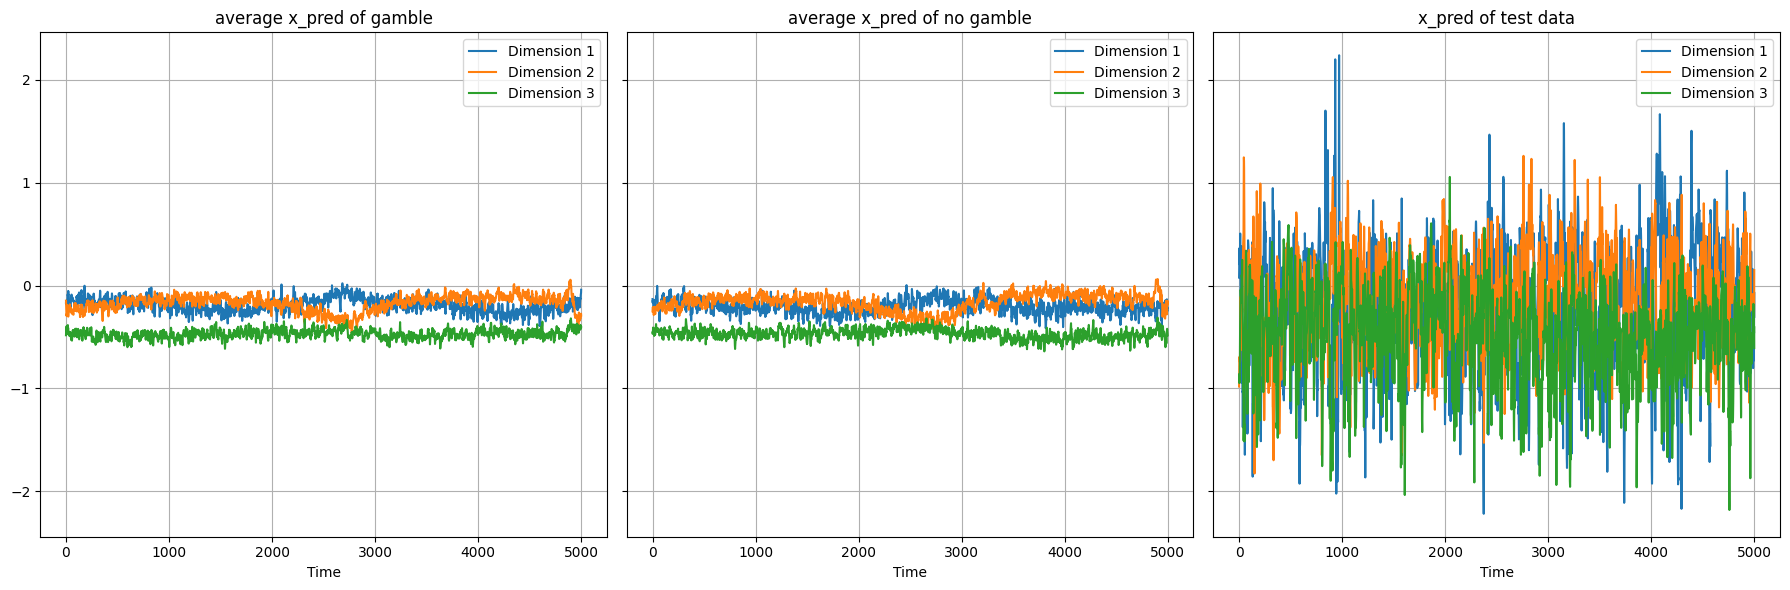

gamble dist:
Distances at each time step: tensor([0.952, 0.885, 0.858,  ..., 0.333, 0.087, 0.552])
Mean distance: 0.8215911388397217
Total distance: 4107.95556640625
no gamble dist:
Distances at each time step: tensor([0.862, 0.827, 0.842,  ..., 0.247, 0.192, 0.360])
Mean distance: 0.8176996111869812
Total distance: 4088.498046875
Actual result: gamble | Predicted result: no gamble


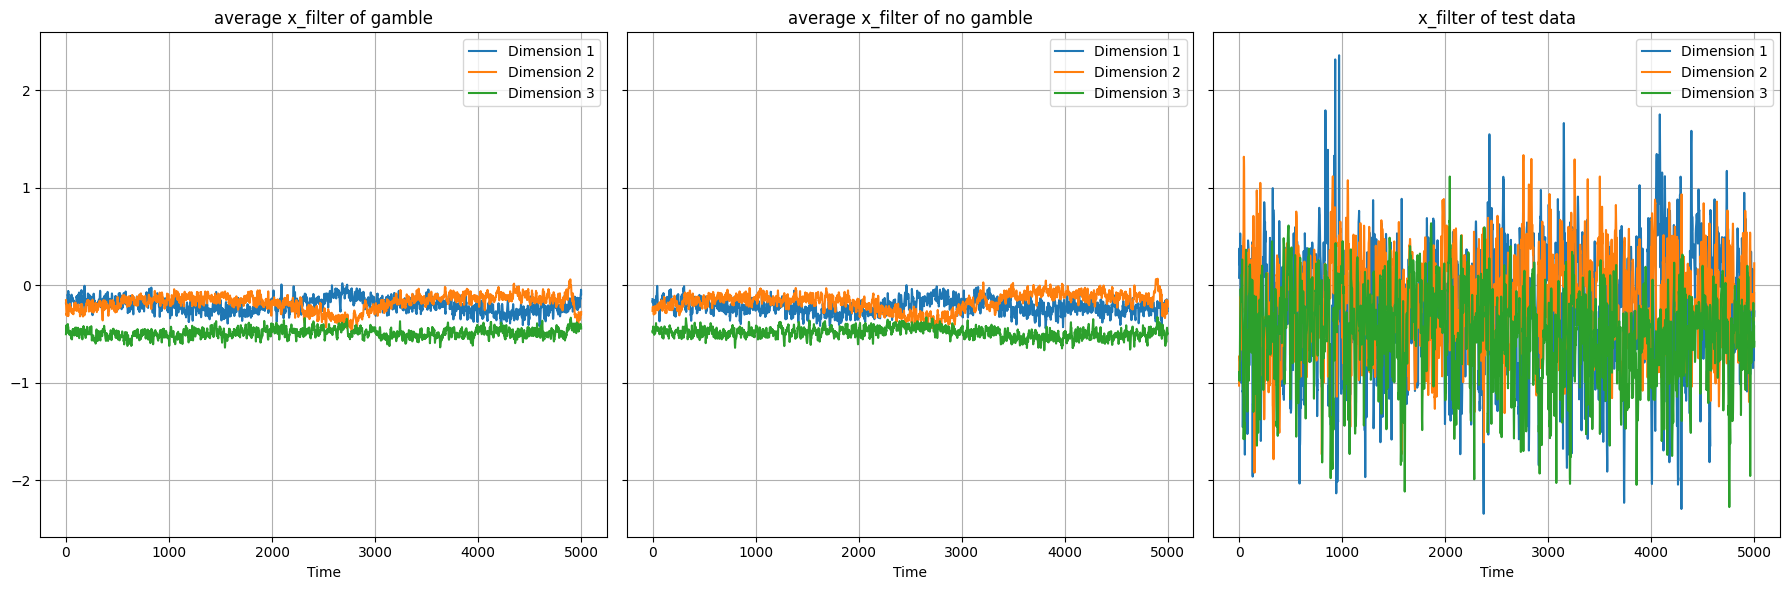

gamble dist:
Distances at each time step: tensor([0.994, 0.922, 0.895,  ..., 0.091, 0.584, 0.547])
Mean distance: 0.8642183542251587
Total distance: 4321.9560546875
no gamble dist:
Distances at each time step: tensor([0.900, 0.861, 0.880,  ..., 0.202, 0.380, 0.451])
Mean distance: 0.8601521849632263
Total distance: 4301.62109375
Actual result: gamble | Predicted result: no gamble


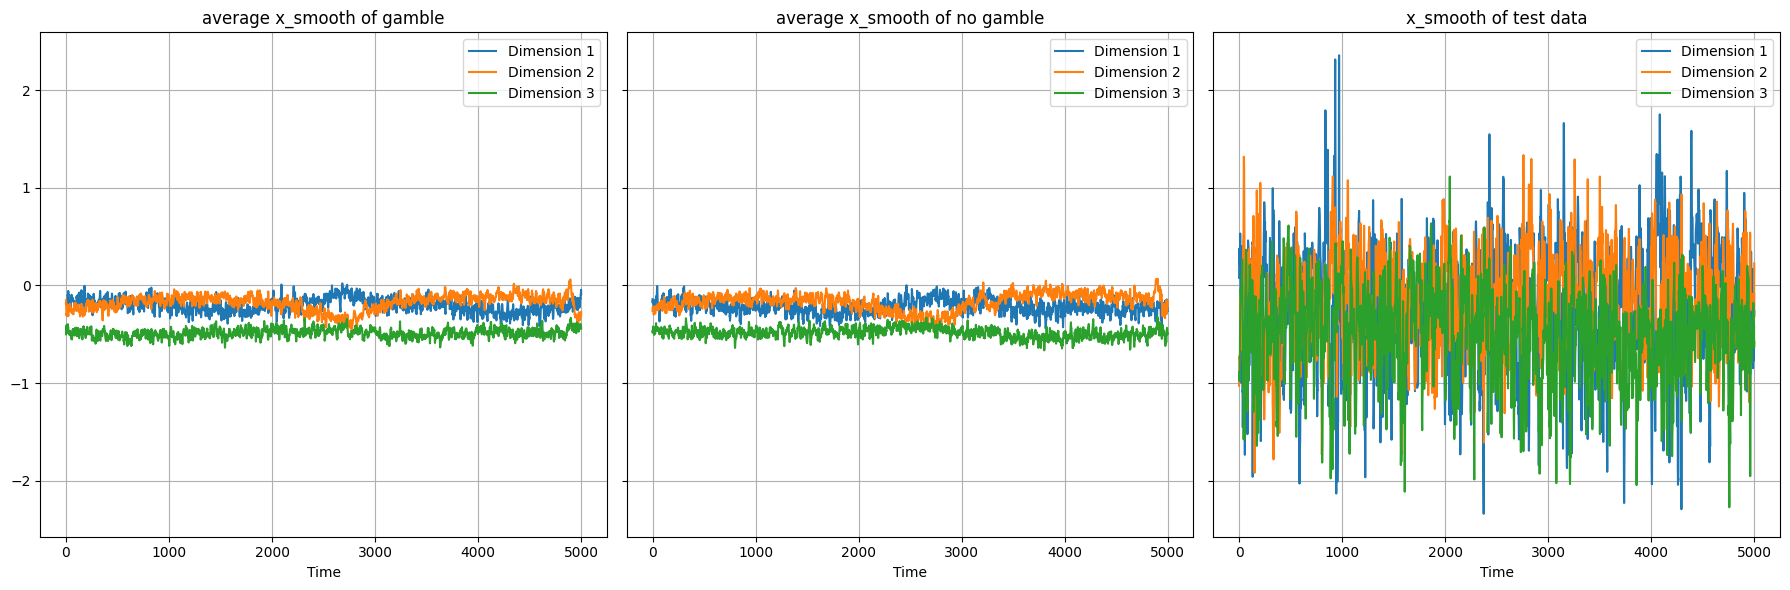

gamble dist:
Distances at each time step: tensor([0.994, 0.922, 0.895,  ..., 0.091, 0.584, 0.547])
Mean distance: 0.8641964197158813
Total distance: 4321.84619140625
no gamble dist:
Distances at each time step: tensor([0.899, 0.860, 0.880,  ..., 0.201, 0.380, 0.451])
Mean distance: 0.8601287603378296
Total distance: 4301.50390625
Actual result: gamble | Predicted result: no gamble


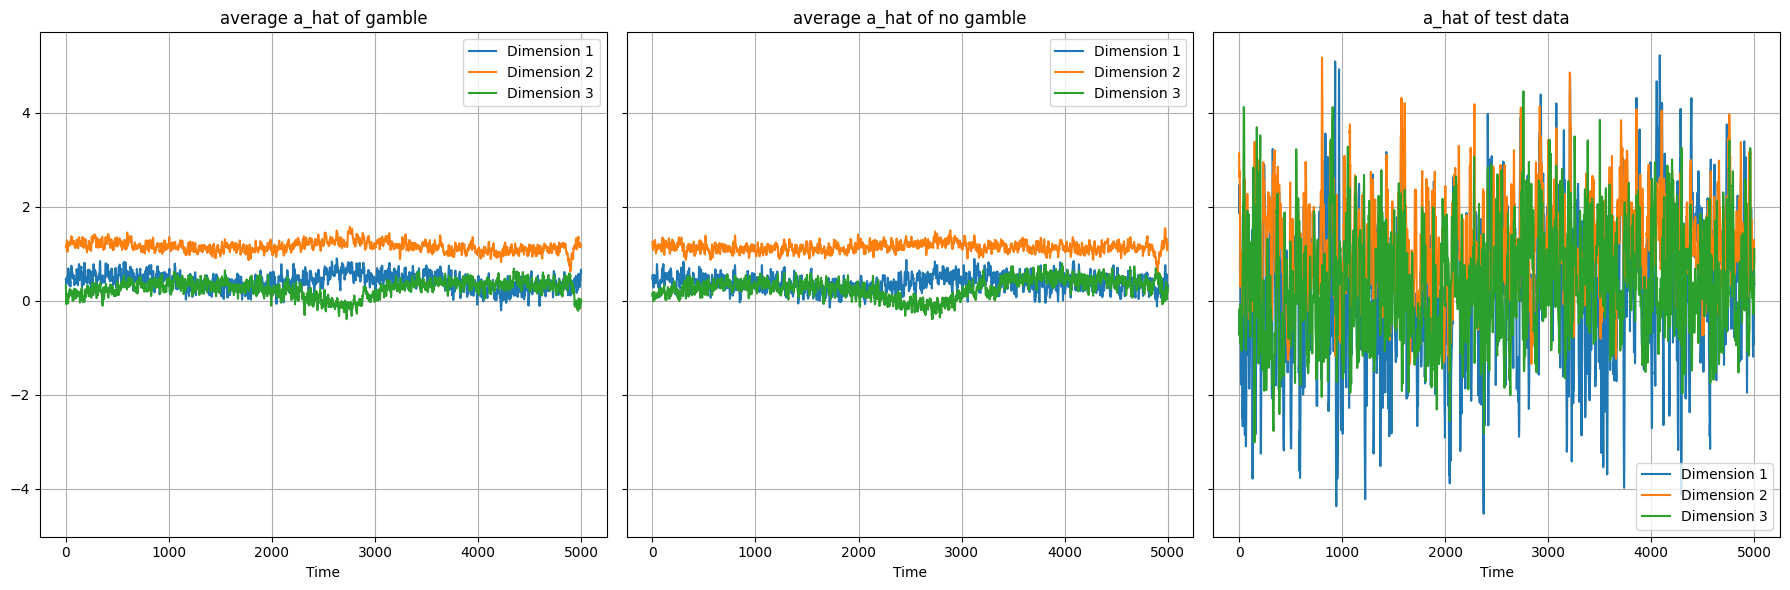

gamble dist:
Distances at each time step: tensor([2.643, 2.548, 2.575,  ..., 0.201, 1.161, 1.147])
Mean distance: 1.9965940713882446
Total distance: 9984.966796875
no gamble dist:
Distances at each time step: tensor([2.444, 2.402, 2.520,  ..., 0.327, 0.814, 0.981])
Mean distance: 1.9810452461242676
Total distance: 9907.20703125
Actual result: gamble | Predicted result: no gamble


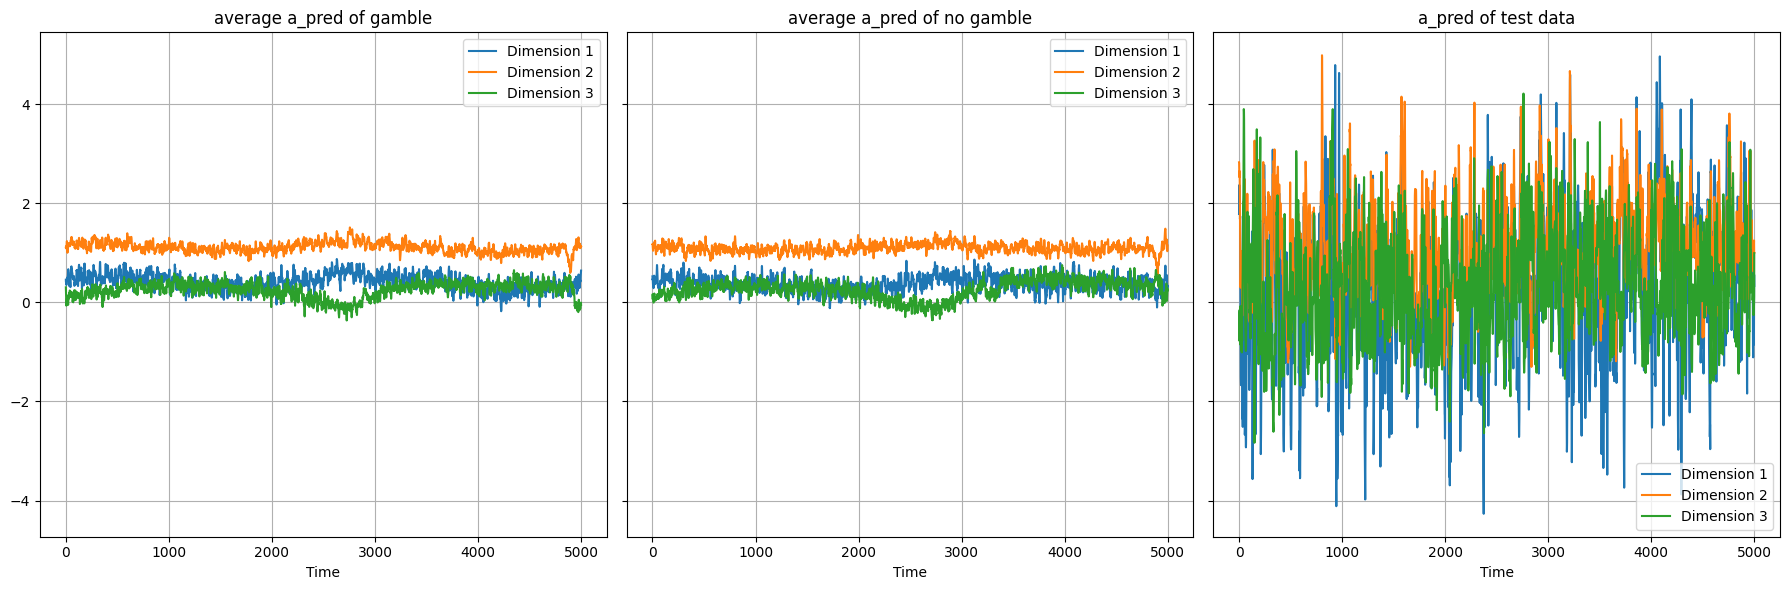

gamble dist:
Distances at each time step: tensor([2.424, 2.451, 2.470,  ..., 0.635, 0.191, 1.097])
Mean distance: 1.8996156454086304
Total distance: 9498.078125
no gamble dist:
Distances at each time step: tensor([2.244, 2.312, 2.417,  ..., 0.511, 0.307, 0.768])
Mean distance: 1.8846845626831055
Total distance: 9423.4228515625
Actual result: gamble | Predicted result: no gamble


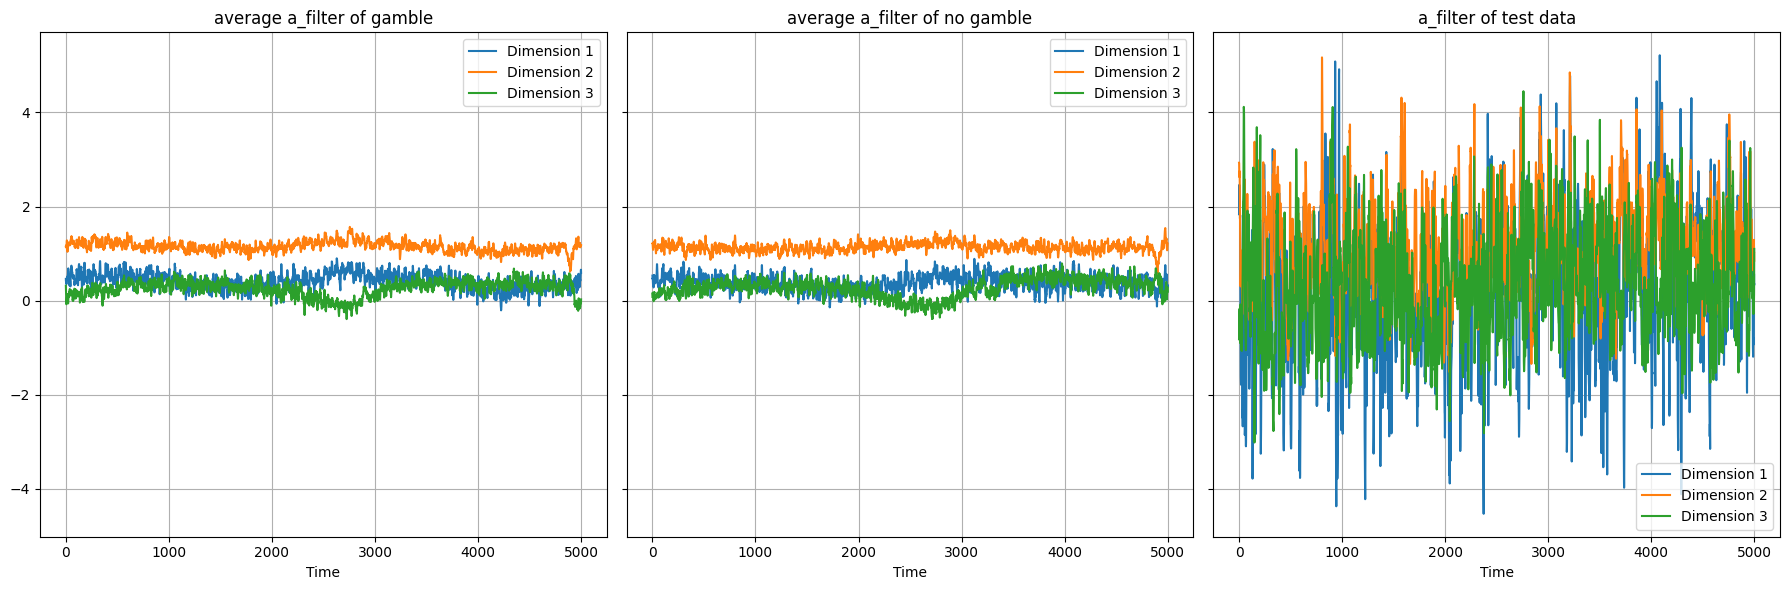

gamble dist:
Distances at each time step: tensor([2.523, 2.548, 2.575,  ..., 0.200, 1.159, 1.147])
Mean distance: 1.9960105419158936
Total distance: 9982.048828125
no gamble dist:
Distances at each time step: tensor([2.333, 2.402, 2.520,  ..., 0.324, 0.812, 0.981])
Mean distance: 1.9804646968841553
Total distance: 9904.3037109375
Actual result: gamble | Predicted result: no gamble


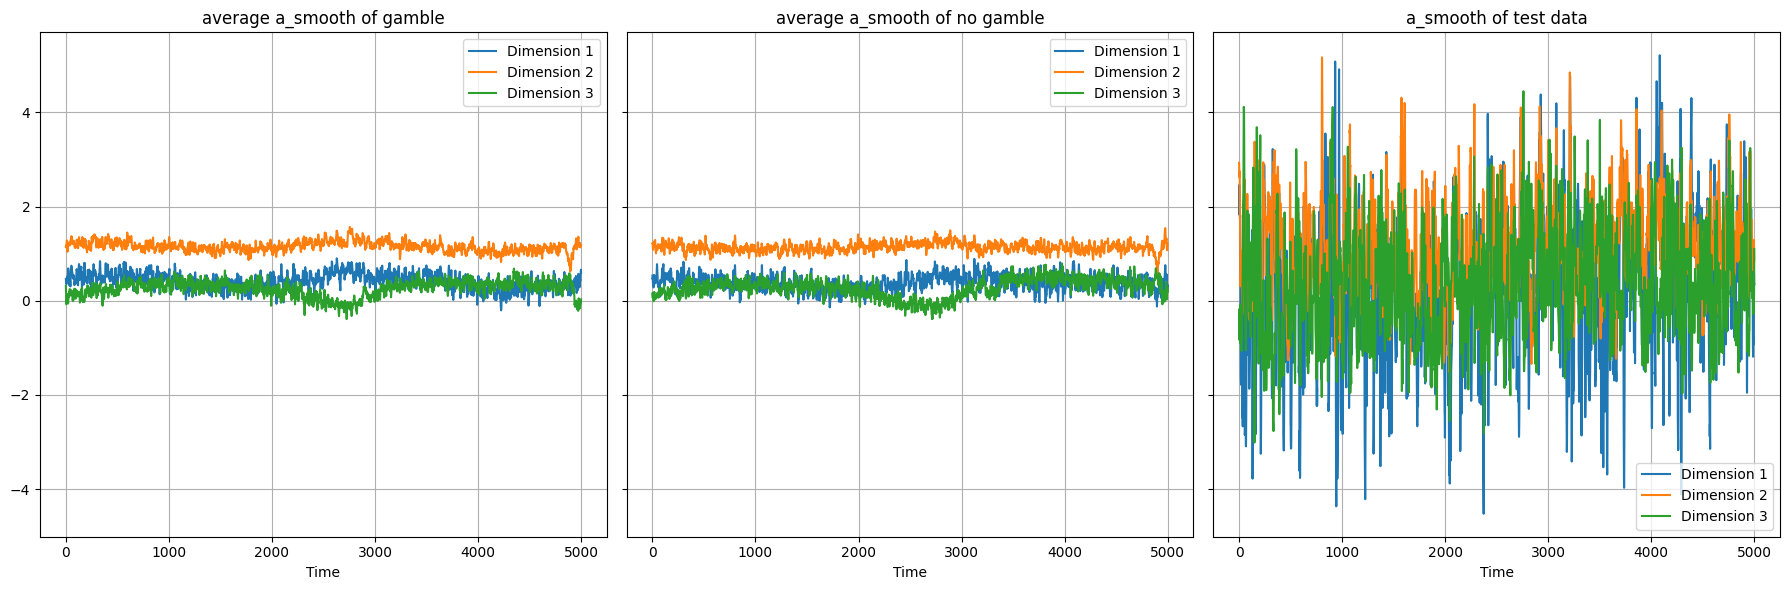

gamble dist:
Distances at each time step: tensor([2.523, 2.547, 2.575,  ..., 0.200, 1.158, 1.147])
Mean distance: 1.9959807395935059
Total distance: 9981.8994140625
no gamble dist:
Distances at each time step: tensor([2.332, 2.402, 2.520,  ..., 0.323, 0.812, 0.981])
Mean distance: 1.9804326295852661
Total distance: 9904.1435546875
Actual result: gamble | Predicted result: no gamble


In [68]:
for key in gamble_latents['train'].keys():
    gamble_avg = gamble_latents['train'][key].squeeze()
    no_gamble_avg = ng_gamble_latents['train'][key].squeeze()
    test_data = test_latents['batch_inference'][key]['train'].squeeze()
    
    data_list = [gamble_avg, no_gamble_avg, test_data]
    label_list = [f"average {key} of gamble", f"average {key} of no gamble", f"{key} of test data"]

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    for ax, label, data in zip(axes, label_list, data_list):
        time = range(data.shape[0])  
        dim_1 = data[:, 0]  
        dim_2 = data[:, 1]  
        dim_3 = data[:, 2]  

        # Plot each dimension
        ax.plot(time, dim_1, label="Dimension 1")
        ax.plot(time, dim_2, label="Dimension 2")
        ax.plot(time, dim_3, label="Dimension 3")

        ax.set_title(label)
        ax.set_xlabel("Time")
        ax.grid()
        ax.legend()

    plt.tight_layout()
    plt.show()
    print("gamble dist:")
    g = findEuclidianDist(test_data, gamble_avg)
    print("no gamble dist:")
    ng = findEuclidianDist(test_data, no_gamble_avg)
    print(f'Actual result: {"gamble" if test_y_type.item() else "no gamble"} | Predicted result: {"gamble" if ng > g else "no gamble"}')


## DFINE can learn the dynamics.

Take avg of all gamble and safe trial (for low dimensional representation)
in low dimensional space, and whichever we're closer to, we classify based on that.

Use x_pred when you need real-time state estimates, as this reflects the state based on the model and past observations up to the current time.
Use x_smooth when you have access to the entire sequence of observations and can refine your state estimates retrospectively for better accuracy.

Next, we plot the one-step ahead normalized root MSE (NRMSE) values of DFINE on the test data throughout the training vs. number of epochs, as well as that of the true system. The true system NRMSE is obtained using a UKF that uses the true system parameters (predictions are provided in the swiss_roll.pt datafile).

Note that DFINE NRMSEs for the test (or validation) dataset are computed by valid_epoch function after every epoch while evaluating the model, and these values are bookkept under the trainer object. Please see TrainerDFINE.py.

a_smooth: Smoothed latent variables during training and validation: use this, the manifold latent factor, as the low dimensional representation.



In [ ]:
from collections import Counter

def euclidean_distance(point1, point2):
    if len(point1) != len(point2):
        raise ValueError("Both points must have the same number of dimensions")

    sum_squared_diff = 0
    for i in range(len(point1)):
        sum_squared_diff += (point1[i] - point2[i]) ** 2

    return math.sqrt(sum_squared_diff)

a_smooth = results['batch_inference']['a_smooth']['valid']
y_res = results['batch_inference']['y_filter']['valid']
print(a_smooth.shape)





3 phases: deliberation, anticipation, result

In [ ]:
def plot_nrmse_convergence(true_one_step_nrmse, dfine_one_step_nrmse_list, resolution=1):
    # Downsample with desired resolution
    num_epochs = len(dfine_one_step_nrmse_list) - 1
    dfine_one_step_nrmse_list = dfine_one_step_nrmse_list[::resolution]
    x = np.arange(0, len(dfine_one_step_nrmse_list))

    # Plot the one-step-ahead prediction NRMSE of DFINE over the course of training, computed by valid_epoch function during model evaluation
    f = plt.figure(figsize=(7,4))
    ax = f.add_subplot(111)
    plt.plot(x, torch.ones(len(dfine_one_step_nrmse_list))*true_one_step_nrmse, color='#239023', label='True model')
    plt.plot(x, dfine_one_step_nrmse_list, color='#8D128D', label='Learned model')
    plt.scatter(0, dfine_one_step_nrmse_list[0], s=100, color='#8D128D', marker='x', linewidth=2, label='Initialized model')

    # Set the ticks
    xticks = np.arange(0, num_epochs+1, resolution)
    ax.set_xticks(x)
    ax.set_xticklabels(xticks)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('One-step-ahead \nprediction error \n(NRMSE)')
    plt.legend()

# One-step-ahead prediction with UKF by using the TRUE system
_, true_test_one_step_nrmse = get_nrmse_error(test_y[:, 1:, :], test_true_y_pred)
# DFINE NRMSEs on the test (or validation) dataset are computed throughout the training
# during model evaluation and bookkept under the trainer object
dfine_test_one_step_nrmse_list = trainer.training_valid_one_step_nrmses

# Plot the NRMSE convergence over the course of training
plot_nrmse_convergence(true_test_one_step_nrmse, dfine_test_one_step_nrmse_list, resolution=25)

We see that DFINE’s one-step ahead NRMSE converges to that of the true model. Now, let's plot a trial of filtered trajectory inferred by DFINE in the test dataset.

In [ ]:
# Filtering with DFINE
dfine_test_y_filter_zsc = encoding_results['batch_inference']['y_filter']['valid']
dfine_test_y_filter = dfine_test_y_filter_zsc * std_y + mean_y # reverting z-scoring

# Plots the true and reconstructed trajectory on the Swiss-roll manifold
def plot_reconst_traj_3D(y, y_hat, y_no_noise, trial):
    num_samples = y.shape[1]
    color_index = range(num_samples)
    color_map = plt.cm.get_cmap('viridis')

    xlim = [y[trial, :, 0].min(), y[trial, :, 0].max()]
    ylim = [y[trial, :, 1].min(), y[trial, :, 1].max()]
    zlim = [y[trial, :, 2].min(), y[trial, :, 2].max()]

    f = plt.figure(figsize=(10,8))
    ax = f.add_subplot(121, projection='3d')
    ax_m = ax.scatter(y_no_noise[trial, :, 0].numpy(), y_no_noise[trial, :, 1].numpy(), y_no_noise[trial, :, 2].numpy(), c=color_index, vmin=0, vmax=num_samples, s=35, cmap=color_map)
    f.colorbar(ax_m, fraction=0.046, pad=0.04, shrink=0.4, location='left')
    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')
    ax.set_zlabel('Dim 3')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    ax.set_title('True underlying trajectory')

    ax = f.add_subplot(122, projection='3d')
    ax_m = ax.scatter(y_hat[trial, :, 0].numpy(), y_hat[trial, :, 1].numpy(), y_hat[trial, :, 2].numpy(), c=color_index, vmin=0, vmax=num_samples, s=35, cmap=color_map)
    ax.scatter(y[trial, :, 0].numpy(), y[trial, :, 1].numpy(), y[trial, :, 2].numpy(), color='#C0C0C0', alpha=0.4) # noisy observations
    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')
    ax.set_zlabel('Dim 3')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    title = 'DFINE Inferred trajectory (filtered)'
    ax.set_title(title)
    plt.show()

# Plot DFINE inferred filtered observations
plot_reconst_traj_3D(test_y, dfine_test_y_filter, test_y_no_noise, trial_plot)

We see that DFINE’s inferred trajectory using causal filtering is nearly identical to the true trajectory. Note that the grey dots on the right are the noisy observations from which DFINE infers the underlying trajectory.

## DFINE enables flexible causal and non-causal inference, even in the presence of missing observations.

Next, we show DFINE's flexible inference performance, whether causally, non-causally, or even with missing observations.

To show DFINE’s ability to handle missing observations, we define different sample dropping probabilities to randomly drop samples of observations over time. Based on these values, we create masks to mask the neural observation samples. We define the observed datapoint ratio as the ratio of the datapoints that are maintained/not-dropped to the total number of datapoints (or equivalently 1-(sample dropping probabilities)). This random drop was done to emulate the common problem of data drop in wireless neural interfaces.

In [ ]:
# DFINE Inference with missing samples
p_drop_list = np.array([0, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95]) # sample drop probability, samples are dropped uniformly across timesteps

# Create masks for inference with missing samples
def create_mask(num_trials, num_steps, p_drop=0):
    keep_probs = torch.ones((num_trials, num_steps), dtype=torch.float32) * (1-p_drop)
    mask = torch.bernoulli(keep_probs)
    return mask.unsqueeze(dim=-1)

For each sample dropping probability, we create corresponding masks and reinitialize the dataloaders with these masks. Then, we call 'trainer.save_encoding_results' function to perform inference with DFINE. Also, for each dropping probability, we compute NRMSEs both with filtering and smoothing.

In [ ]:
dfine_nrmse_filter_list, dfine_nrmse_smooth_list = [], []
dfine_y_filter_list, dfine_y_smooth_list = [], []

mask_list = []

for p_drop in p_drop_list:
    train_mask = create_mask(num_train_trials, num_steps, p_drop)
    test_mask = create_mask(num_test_trials, num_steps, p_drop)
    mask_list.append(test_mask)

    # Create DFINE dataset objects and torch dataloaders
    train_dataset_drop = DFINEDataset(y=train_y_zsc, mask=train_mask)
    test_dataset_drop = DFINEDataset(y=test_y_zsc, mask=test_mask)

    train_loader_drop = DataLoader(train_dataset_drop, batch_size=config.train.batch_size, shuffle=False)
    test_loader_drop = DataLoader(test_dataset_drop, batch_size=config.train.batch_size, shuffle=False)

    # Perform inference over the dataset with missing samples
    encoding_results_drop = trainer.save_encoding_results(train_loader=train_loader_drop,
                                                          valid_loader=test_loader_drop,
                                                          save_results=False)

    # Obtain DFINE inferred neural activity reconstructions (with filtering and smoothing) with missing samples
    dfine_test_y_filter_zsc_drop = encoding_results_drop['batch_inference']['y_filter']['valid']
    dfine_test_y_smooth_zsc_drop = encoding_results_drop['batch_inference']['y_smooth']['valid']

    dfine_test_y_filter_drop = dfine_test_y_filter_zsc_drop * std_y + mean_y # reverting z-scoring
    dfine_test_y_smooth_drop = dfine_test_y_smooth_zsc_drop * std_y + mean_y # reverting z-scoring

    # Compute NRMSE of DFINE, filtering and smoothing
    _, dfine_test_filter_nrmse = get_nrmse_error(test_y_no_noise, dfine_test_y_filter_drop)
    _, dfine_test_smooth_nrmse = get_nrmse_error(test_y_no_noise, dfine_test_y_smooth_drop)

    # Keep NRMSE stats and inferred variables in a list for plotting
    dfine_nrmse_filter_list.append(dfine_test_filter_nrmse)
    dfine_nrmse_smooth_list.append(dfine_test_smooth_nrmse)

    dfine_y_filter_list.append(dfine_test_y_filter_drop)
    dfine_y_smooth_list.append(dfine_test_y_smooth_drop)

Let's plot the DFINE NRMSE values obtained with filtering and smoothing over defined observed datapoint ratios (or 1-(sample dropping probabilities)).

We can see that the same trained DFINE model can perform both filtering and smoothing, and can do so with or without missing observations. Also, the difference between filtering and smoothing is larger in the low information regime, that is for low observed datapoint ratios.

Finally, let's visualize the DFINE inferred filtered and smoothed trajectories for observed datapoint ratio of 0.1 (or sample dropping probability of 0.9).

In [ ]:
obs_ratios = [f'{1-i:.2f}' for i in p_drop_list]
f = plt.figure()
ax = f.add_subplot(111)
plt.plot(np.arange(len(p_drop_list)), dfine_nrmse_filter_list[::-1], marker='.', label='Filtering', color='#008B8B')
plt.plot(np.arange(len(p_drop_list)), dfine_nrmse_smooth_list[::-1], marker='.', label='Smoothing', color='#000080')
ax.set_xticks(np.arange(len(p_drop_list)))
ax.set_xticklabels(obs_ratios[::-1])
ax.set_xlabel('Observed datapoint ratio')
ax.set_ylabel('Underlying trajectory \nreconstruction error \n(NRMSE)')
plt.xticks(rotation=30)
plt.legend()
plt.show()

Note that the left-most plot is for visualization and shows that only 10% of the underlying trajectory will be observed in noisy neural observations. This means that only the noisy neural observations associated with the colored dots on the trajectory are used for inference, and all other neural observations (associated with all the other points of trajectory) are missing during inference.